# tf_flower 데이터셋을 이용하여 꽃 이미지 분류기 모델 만들기

<br>

## 개요
지금까지 학습한 모든 내용을 통째로 활용해서, 꽃 이미지를 분류하는 모델을 만들어본다.  
이 전에 학습했던 Dogs_vs_Cats 데이터셋을 활용한 이미지 분류 모델을 참고하여 양질의 모델을 생성한다.  

## 목차
1. 데이터셋 내려받기
    * 필요한 라이브러리 가져오기
    * 학습에 사용될 하이퍼 파라미터 전역변수 설정
    * tf_flowers 데이터를 학습 데이터, 검증 데이터, 평가 데이터로 분리
    * 데이터의 형태와 크기 확인
2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
    * 데이터의 크기와 형태를 동일하게 변환
    * 데이터 배치 진행
    * 변환된 데이터의 형태와 크기 확인
3. 모델 설계하기
    * pre-trained 모델 불러오기
    * 불러온 모델 구조 확인
    * 추가적인 layer 설계
    * 모델 구조 확인
    * 최종적으로 학습시킬 모델 생성
4. 모델 학습시키기
    * 학습시키기 전 모델의 성능 확인
    * 모델 학습 진행
    * 학습 진행에 따른 정확도 시각화
5. 모델 성능 평가하기
    * 평가 결과 확인
    * 평가 결과 시각화
    * 평가 데이터에 대한 정확도 확인
6. 모델 활용하기
    * 모델 저장
    * 임의의 꽃 이미지를 가져와서 이미지 분류기 활용

### 1. 데이터셋 내려받기
---

#### 필요한 라이브러리 가져오기
* 전체적인 코드를 파악하여 프로젝트에 필요한 코드를 미리 import한다.

In [18]:
# 경고 메세지 관련 라이브러리
import warnings
import tensorflow as tf
# 데이터셋 관련 라이브러리
import tensorflow_datasets as tfds
# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import numpy as np
import os
# 이미지 로드 관련 라이브러리
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# 모델 구조 파악을 위한 라이브러리
from tensorflow.keras.utils import plot_model

In [2]:
# 경고 메세지를 무시하도록 설정
warnings.filterwarnings('ignore')

In [3]:
# 충돌 가능성이 있는 라이브러리 버전 확인
print(tf.__version__)
print(tfds.__version__)

2.15.0
4.9.4


라이브러리는 수시로 업데이트가 되기 때문에 버전 간의 호환성 문제가 발생할 수 있다.  
프로젝트 진행 중 발생할 수 있는 라이브러리 버전 간의 충돌에 대비하여 미리 사용하는 라이브러리의 버전을 확인한다.

#### 학습에 사용될 하이퍼 파라미터 전역변수 설정
* 모델의 성능에 영향을 줄 수 있는 하이퍼 파라미터를 전역변수로 지정하여 미리 초기화시켜 놓는다.

In [4]:
# 이미지의 크기
IMG_SIZE = 160
# 이미지의 형태
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# 메모리 사용량 조절을 위해 배치 크기는 16으로 설정
BATCH_SIZE = 16
# 메모리 사용량 조절을 위해 버퍼 크기는 500으로 설정
SHUFFLE_BUFFER_SIZE = 500
# 학습률
LEARNING_RATE = 0.001
# 에폭 당 20번의 검증 수행
VALIDATION_STEP = 20
# 원활한 학습을 위해 10 에폭 수행
EPOCHS = 10

#### tf_flowers 데이터셋을 불러와 학습 데이터, 검증 데이터, 평가 데이터로 분리
* tensorflow_datasets 라이브러리의 load 메서드를 사용하여 tf_flowers 데이터셋을 불러오고, 8:1:1의 비율로 데이터셋을 분할한다.

In [5]:
# 지정한 경로에 tf_flowers 데이터셋을 다운로드하고 데이터셋을 각각 학습 데이터, 검증 데이터, 평가 데이터로 분리
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/git/Aiffel_Node/Data/flower/',
    download=True,
    with_info=True,
    as_supervised=True,
)

2024-01-03 11:41:33.574746: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /Users/leeseonjae/git/Aiffel_Node/Data/flower/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [6]:
# 분리한 데이터 정보 확인
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


세 종류로 분리된 데이터셋의 채널은 3으로 모두 동일하지만, 모든 이미지의 크기가 제각각이기 때문에 이미지의 크기 인덱스는 None으로 출력된다. 레이블의 shape은 스칼라 값(단일값)이기 때문에 공백으로 표시된다.  
이미지를 일부 로드하여 실제로 어떻게 생겼는지 확인해보도록 한다.

In [7]:
# 노트북 내에 그림을 표시하도록 설정
%matplotlib inline
# 사용하는 디스플레이가 레티나가 아니라면 굳이 설정할 필요는 없다.
%config InlineBackend.figure_format = 'retina'

2024-01-03 11:54:46.024630: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


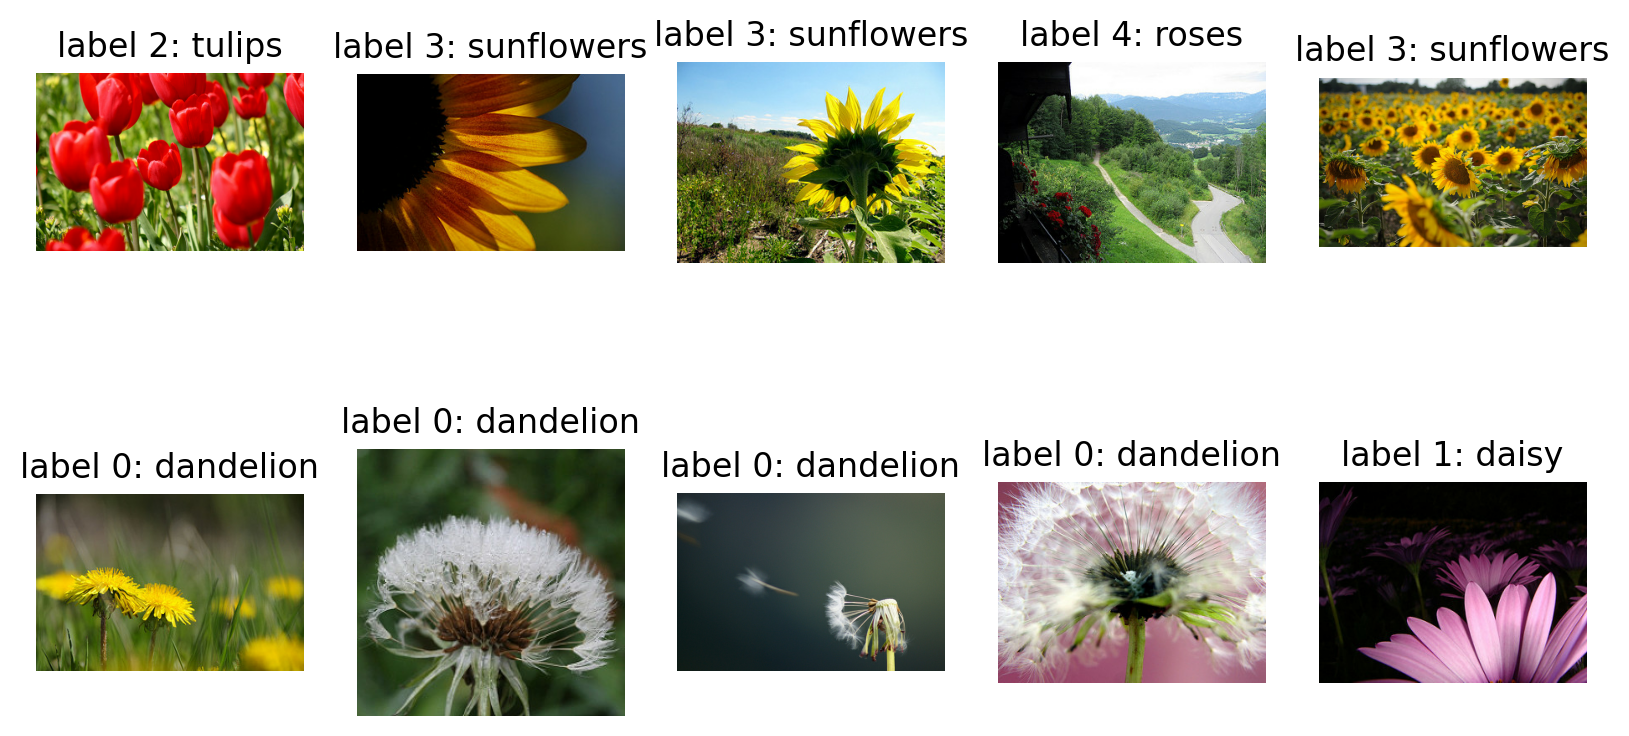

In [8]:
plt.figure(figsize=(10,5))

# 레이블 값을 String으로 변환
get_label_name = metadata.features['label'].int2str

# 학습 데이터에서 10장을 뽑아 시각화하여 데이터 확인
for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

이미지의 크기가 제각각인 것을 확인할 수 있고, 레이블은 {0:민들레, 1:데이지, 2:튤립, 3:해바라기, 4:장미}인 것을 알 수 있다.  
위의 자료에서는 장미가 보이지 않지만, 나오지 않은 레이블이 장미밖에 없기에 유추가 가능하다.

### 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
---

#### 데이터의 크기와 형태를 동일하게 변환
* 제각각의 크기를 가진 데이터를 모델이 학습을 원활하게 진행할 수 있도록 크기를 동일하게 변환하고, 픽셀값을 -1과 1사이로 정규화시킨다.

In [9]:
# 이미지 변환 함수 정의
def format_example(image, label):
    # 이미지의 픽셀값이 -1에서 1 사이가 되도록 처리
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    # 전역변수로 선언했던 사이즈로 이미지 변환
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    return image, label

In [10]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# 변환된 데이터 형태 확인
print(train)
print(validation)
print(test)

<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


데이터의 형태가 (None, None, 3)에서 (160, 160, 3)으로 동일하게 변환된 것을 확인할 수 있다.

2024-01-03 12:05:09.949980: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


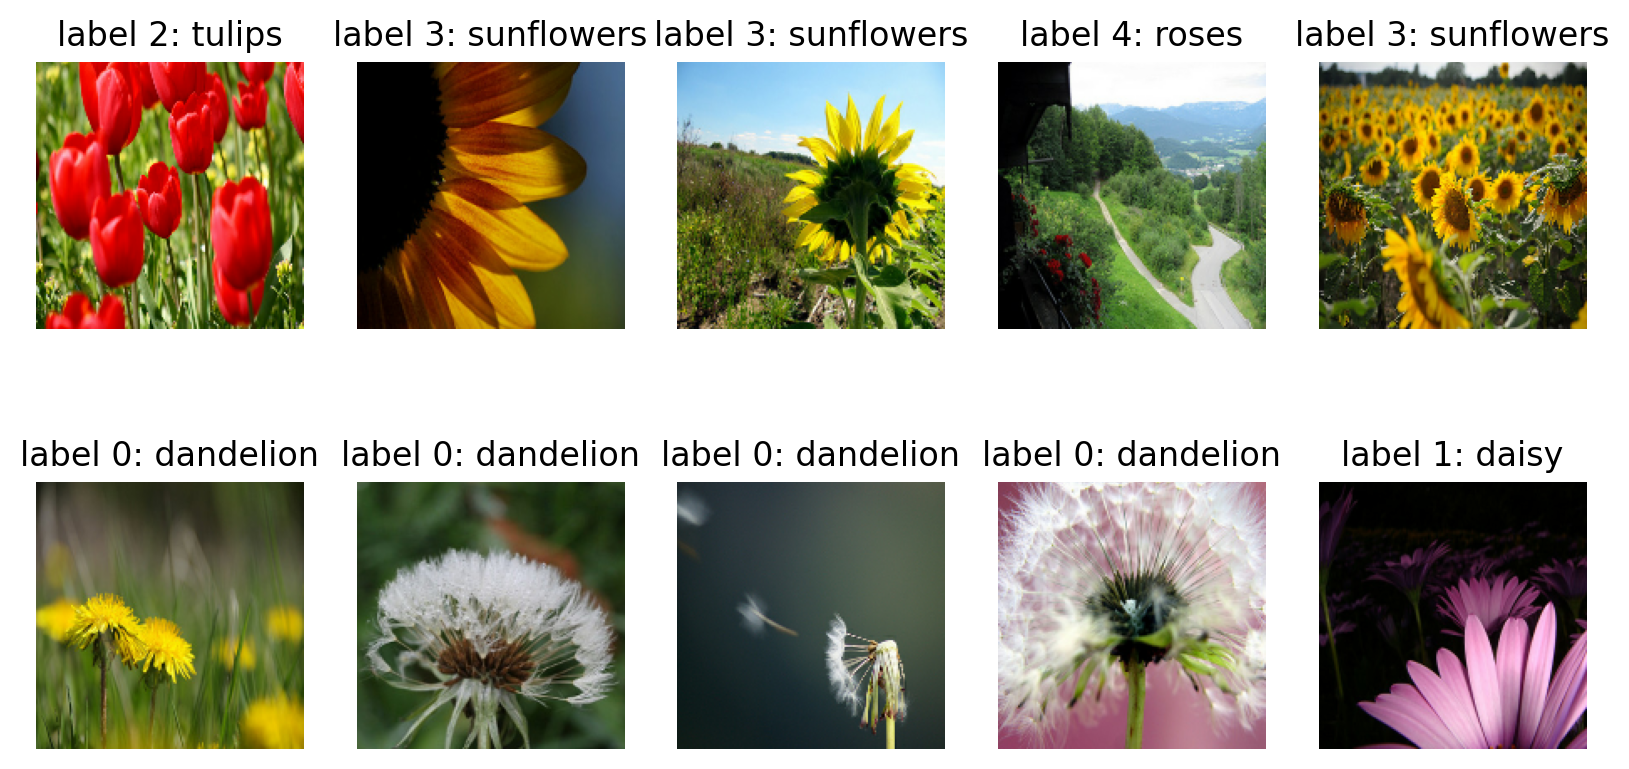

In [12]:
plt.figure(figsize=(10,5))

# 실제로 변환된 이미지 데이터 확인
for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

이미지의 크기가 제각각이었던 처음과 달리 정사각형의 형태로 동일하게 변환된 것을 알 수 있다.

#### 데이터 배치 진행
* 전역 변수로 설정한 배치 크기와 버퍼 크기에 맞게 각각의 데이터셋에 대한 배치 처리를 진행한다.

In [13]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

#### 변환된 데이터의 형태와 크기 확인
* 최종적으로 전처리가 완료된 데이터를 샘플링하여 그 형태와 크기를 확인한다.

In [14]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

2024-01-03 12:10:45.072483: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(TensorShape([16, 160, 160, 3]), TensorShape([16]))

1개의 배치 당, 160X160 크기의 3채널 이미지 데이터 16개가 들어 있고, 그에 매핑되는 스칼라 값을 가진 16개의 레이블 데이터를 확인할 수 있다.

### 3. 모델 설계하기
---

#### pre-trained 모델 불러오기
* 성능이 좋았던 VGG16 모델을 불러온다.

In [15]:
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')

In [16]:
# VGG16 모델 output 확인
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([16, 5, 5, 512])

(16, 160, 160, 3)의 형태였던 데이터가 VGG16 모델을 통과했을 때 (16, 5, 5, 512)로 변한 것을 확인할 수 있다.  
여러 방법을 통해 VGG16의 레이어와 각 레이어를 통과했을 때의 데이터 변화를 확인해본다.

#### 불러온 모델 구조 확인
* summary() 메서드와 plot_model() 메서드를 이용하여 VGG16 모델의 구조를 파악한다.

In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

VGG16모델은 다섯 개의 Convolutional 블럭으로 구성되어 있는 것을 확인할 수 있고, 각각의 블럭 구성은 아래와 같다.  
* 첫 번째 블럭: Convolution layer 2개, Pooling layer 한 개  
* 두 번째 블럭: Convolution layer 2개, Pooling layer 한 개
* 세 번째 블럭: Convolution layer 3개, Pooling layer 한 개
* 네 번째 블럭: Convolution layer 3개, Pooling layer 한 개
* 다섯 번째 블럭: Convolution layer 3개, Pooling layer 한 개

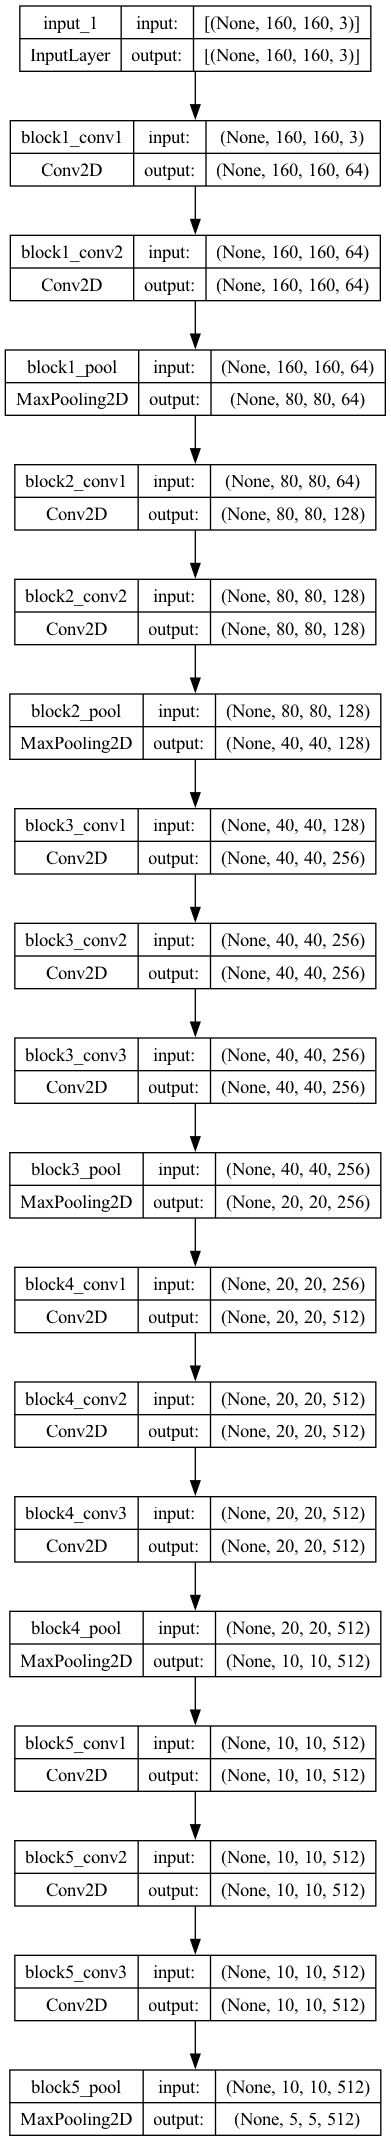

In [19]:
# 모델 구조파악 시각화
plot_model(base_model, show_shapes=True, to_file='naive_inception_module.png')

#### 추가적인 layer 설계
* 데이터의 개수가 3,670개밖에 되지 않기 때문에 Convolutional base는 VGG16모델을 그대로 사용하고, fully connected 레이어만 따로 설계하도록 한다.
* VGG16 모델과 완전연결계층을 연결하려면 VGG16의 output 데이터가 1차원 벡터의 형태를 하고 있어야 하기 때문에 global average layer를 추가한다.

In [20]:
# VGG16 모델의 output을 그대로 GlobalAveragePooling 계층의 input으로 연결
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [21]:
# 연산량 조절을 위해 사용 노드 수는 128으로 설정
dense_layer = tf.keras.layers.Dense(units=128,activation='relu')
# 예측을 해야하는 총 클래스의 개수가 5개이므로, 최종 출력 노드 개수는 5개로 설정
prediction_layer = tf.keras.layers.Dense(units=5, activation='softmax')

prediction_batch = prediction_layer(dense_layer(feature_batch_average))
print(prediction_batch.shape)

(16, 5)


#### 모델 구조 확인
* VGG16 - global average pooling layer - fully connected layer로 구성된 모델을 설계하고 그 구조를 확인한다.

In [22]:
# VGG16 모델은 학습을 진행하지 않도록 설정
base_model.trainable = False

# Sequential API를 사용하여 앞서 만든 계층을 잇는 모델 정의
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 14780997 (56.39 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


위에서 먼저 확인한 복잡한 구조의 Convolutional base 부분인 VGG16 모델은 요약되어서 출력된다.

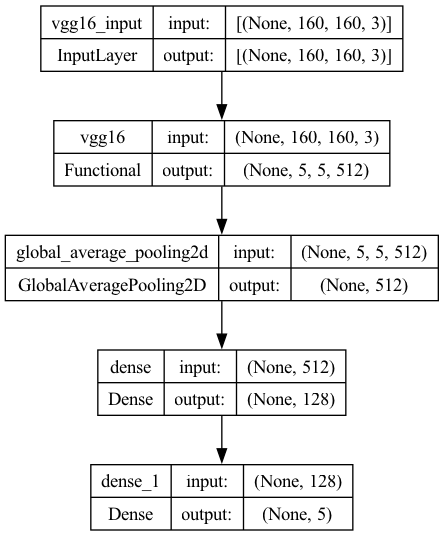

In [25]:
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

최종적으로 설계한 모델의 구조는 위의 그래프와 같다.

#### 최종적으로 학습시킬 모델 생성
* 옵티마이져와 학습률, 손실함수와 평가지표를 지정하여 최종적으로 학습을 진행시킬 모델을 compile한다.

In [26]:
# 옵티마이져: Adam, 학습률: 초기 설정 전역변수, 손실함수: cross-entropy, 평가지표: 정확도
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = LEARNING_RATE),
             loss = tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

다중 클래스 분류인 경우에 속하며, 레이블이 정수의 형태이므로 sparse_categotical_crossentropy 손실함수를 사용한다.

### 4. 모델 학습시키기
---

#### 학습시키기 전 모델 성능 확인
* 학습을 진행하기 전 모델의 성능을 검증 데이터를 통해 확인한다.

In [27]:
loss0, accuracy0 = model.evaluate(validation_batches, steps= VALIDATION_STEP)

print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

20/20 [==============================] - 17s 834ms/step - loss: 1.6313 - accuracy: 0.2094
initial loss: 1.63
initial accuracy: 0.21


다섯 개의 클래스가 골고루 0.21씩 출력되는 것으로 확인된다. 이제 모델을 학습시켜보기로 한다.

#### 모델학습 진행
* 미리 정해놓은 에폭만큼 모델 학습을 진행한다.

In [28]:
# 에폭 10
history = model.fit(train_batches,
                   epochs = EPOCHS,
                   validation_data=validation_batches)

Epoch 1/10
184/184 [==============================] - 182s 986ms/step - loss: 0.9148 - accuracy: 0.6713 - val_loss: 0.6223 - val_accuracy: 0.7738
Epoch 2/10
184/184 [==============================] - 184s 1000ms/step - loss: 0.5778 - accuracy: 0.8035 - val_loss: 0.5354 - val_accuracy: 0.8202
Epoch 3/10
184/184 [==============================] - 182s 990ms/step - loss: 0.4886 - accuracy: 0.8379 - val_loss: 0.5283 - val_accuracy: 0.8120
Epoch 4/10
184/184 [==============================] - 183s 997ms/step - loss: 0.4379 - accuracy: 0.8518 - val_loss: 0.5371 - val_accuracy: 0.7902
Epoch 5/10
184/184 [==============================] - 186s 1s/step - loss: 0.4024 - accuracy: 0.8641 - val_loss: 0.4677 - val_accuracy: 0.8311
Epoch 6/10
184/184 [==============================] - 180s 976ms/step - loss: 0.3780 - accuracy: 0.8726 - val_loss: 0.5086 - val_accuracy: 0.8202
Epoch 7/10
184/184 [==============================] - 185s 1s/step - loss: 0.3438 - accuracy: 0.8856 - val_loss: 0.4664 - val_

에폭을 진행할수록 학습 정확도는 67%에서 90%까지 증가하였고, 학습 손실율은 0.91에서 0.28까지 하락하는 형태로 미루어보아 학습이 잘 진행되었음을 알 수 있다.  
또한, 검증 정확도는 77%에서 84%로 증가하였고, 검증 손실율은 0.62에서 0.44로 하락하는 형태로 학습 정확도보다는 다소 미미한 변화를 보여주고 있지만, 학습과 검증의 차이가 크지 않아 오버피팅 문제는 발생하지 않았다는 것을 알 수 있다. 

#### 학습 진행에 따른 정확도 시각화
* 에폭을 진행함에 따른 정확도와 손실율의 변화를 시각화하여 그 차이를 분석한다.

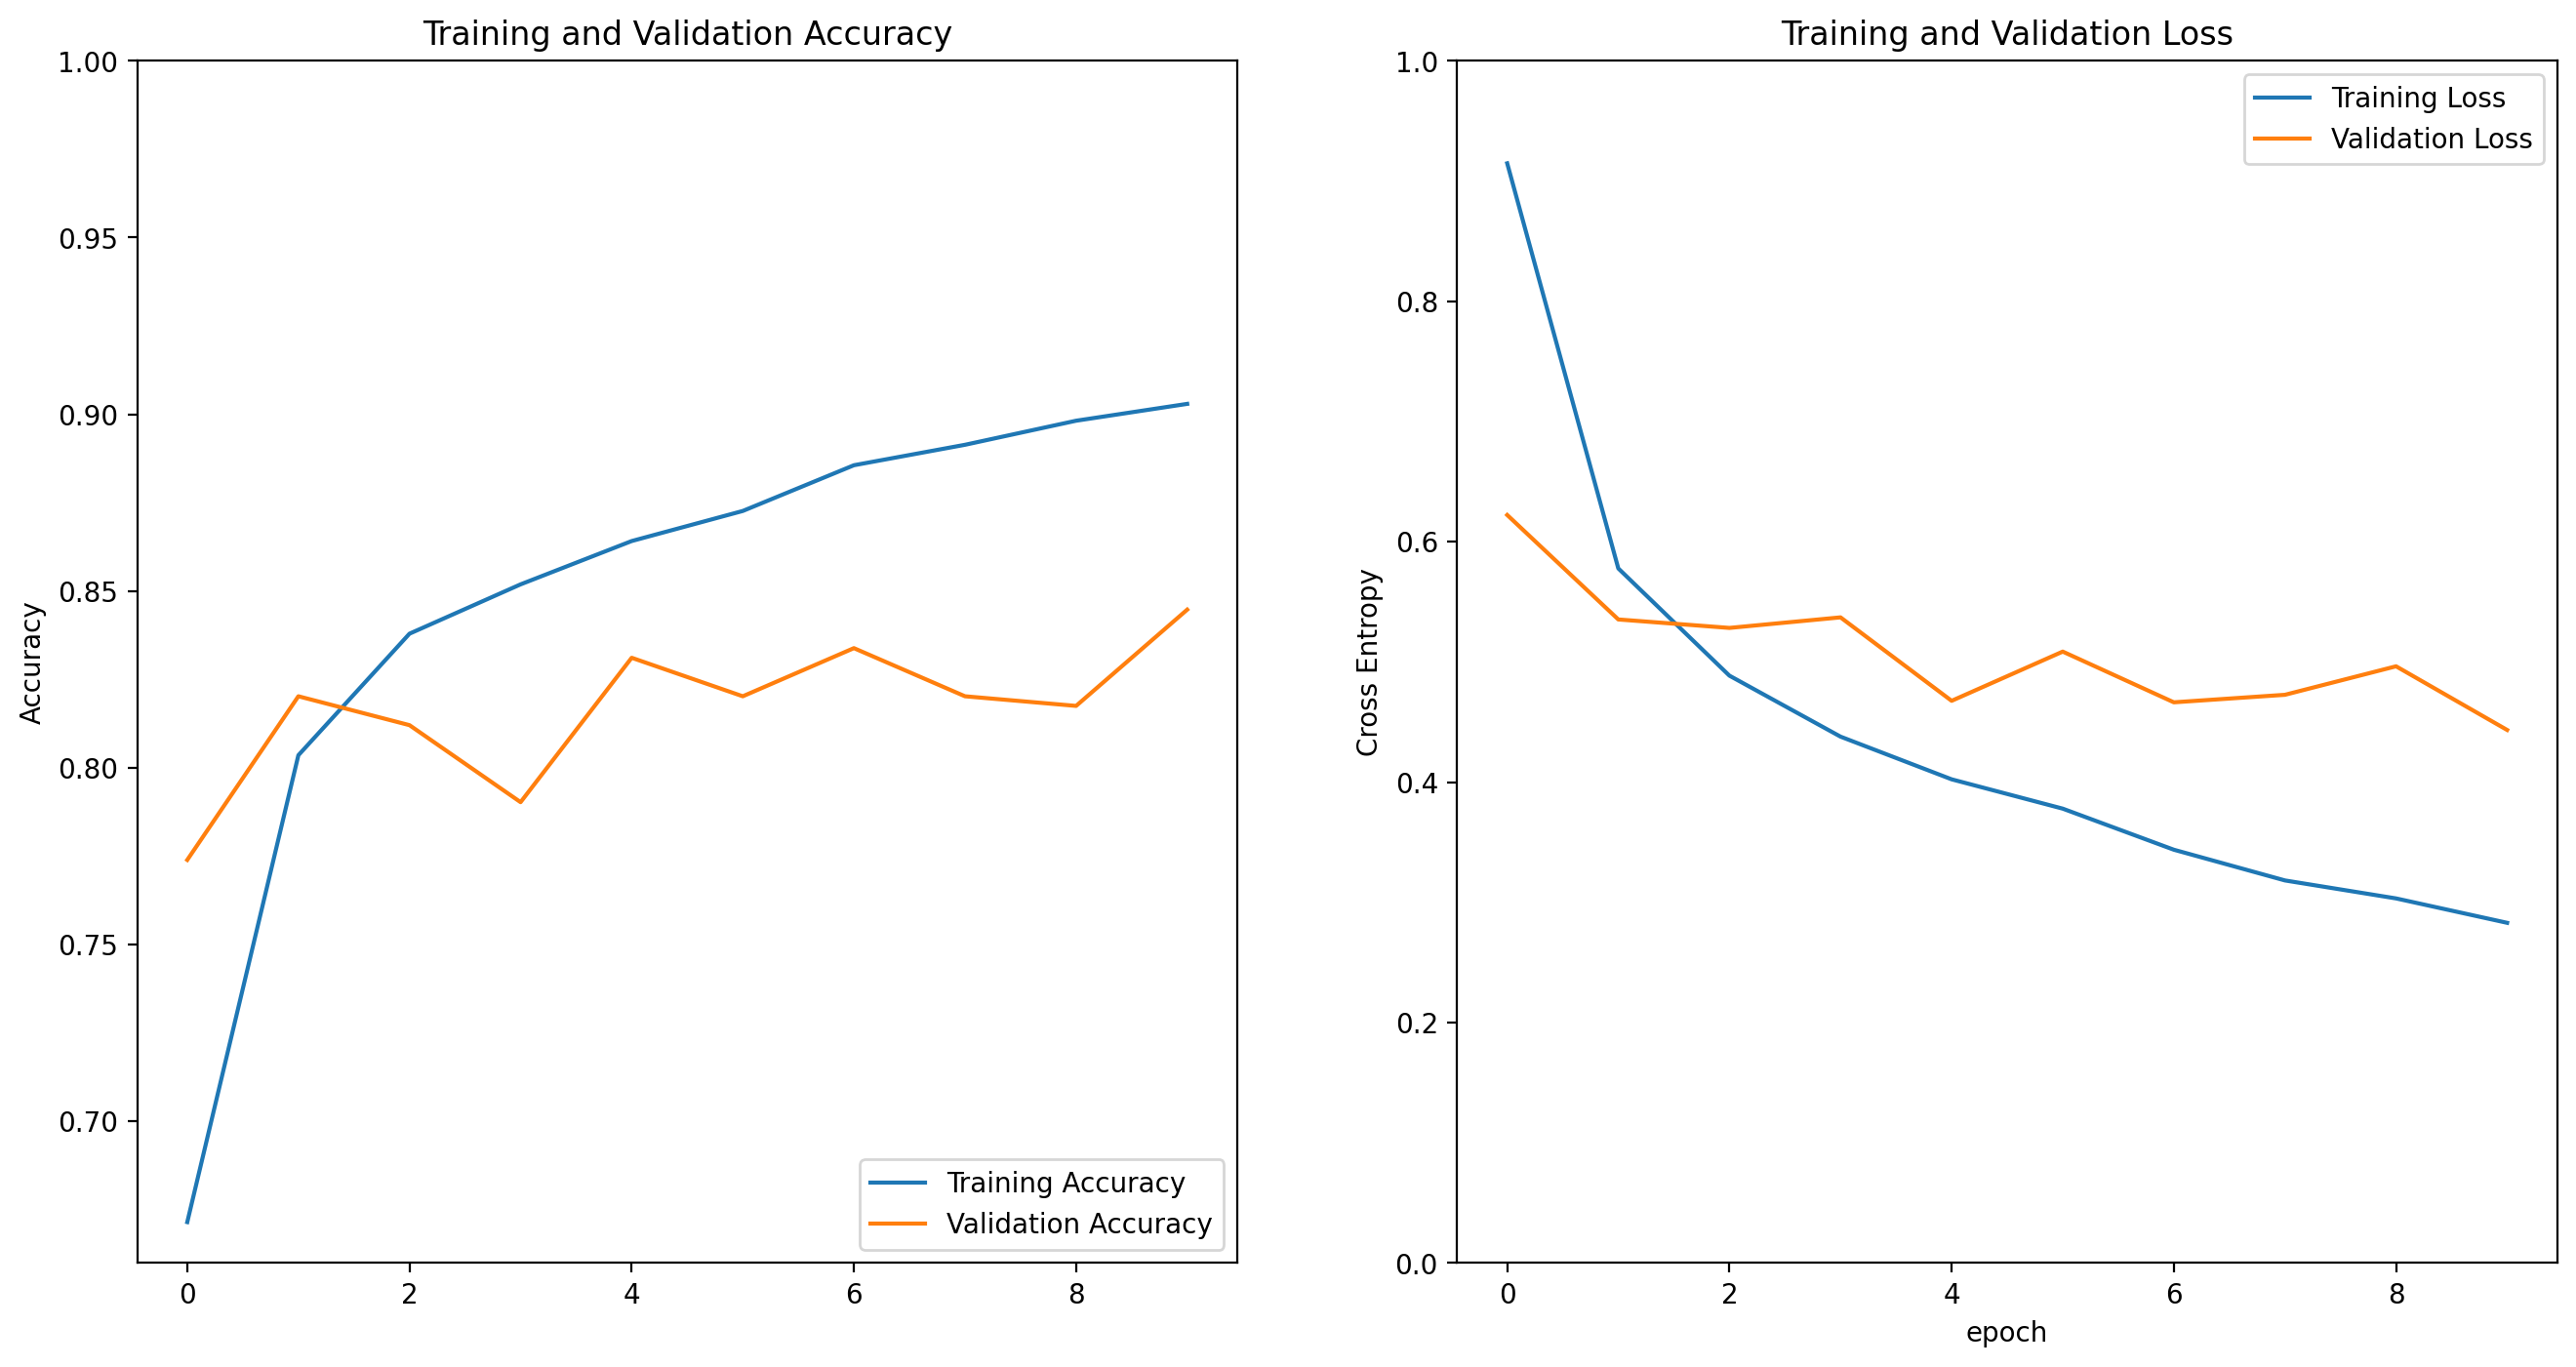

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# 학습 진행에 따른 정확도의 변화
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# 학습 진행에 따른 손실율의 변화
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

위에서 설명한 것을 그래프로 확인한 결과, 검증 결과가 그다지 높지는 않지만 그래프의 추이가 비교적 예쁜 모양을 하고 있으므로 평가를 진행해보도록 한다.

### 모델 성능 평가하기
---

#### 평가 결과 확인
* 평가 데이터의 분류 결과를 보고 각 클래스 별로 어느 정도의 값이 출력됐는지를 확인한다.

In [54]:
# test_accuracy 측정
test_loss, test_accuracy = model.evaluate(test_batches, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

23/23 - 19s - loss: 0.4150 - accuracy: 0.8556 - 19s/epoch - 847ms/step
test_loss: 0.4149726331233978
test_accuracy: 0.8555858135223389


검증 결과보다 약 2% 낮은 정확도가 출력되었다.

In [30]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    # 평가 데이터를 통한 모델 성능 평가
    predictions = model.predict(image_batch)
    pass

predictions

1/1 [==============================] - 1s 934ms/step


array([[2.10457820e-05, 2.51521968e-04, 1.43363908e-01, 8.07051256e-04,
        8.55556488e-01],
       [3.02677974e-04, 9.98768866e-01, 4.56951857e-05, 8.64735048e-04,
        1.80328461e-05],
       [3.44728527e-04, 9.09993947e-01, 6.46644039e-03, 8.22091401e-02,
        9.85720195e-04],
       [9.84484792e-01, 9.80270634e-05, 1.17191084e-04, 1.51813840e-02,
        1.18691292e-04],
       [4.36101928e-02, 9.56325293e-01, 2.99412186e-05, 3.04936675e-05,
        4.12558620e-06],
       [3.33042453e-06, 9.99980688e-01, 8.82396364e-07, 1.50998094e-05,
        5.43485035e-09],
       [4.52827523e-03, 1.19751925e-02, 1.15747796e-03, 9.76761460e-01,
        5.57759404e-03],
       [9.89957273e-01, 5.29816421e-03, 5.10057202e-04, 2.27011205e-03,
        1.96441868e-03],
       [1.47916412e-03, 5.16579393e-03, 3.67895871e-01, 2.22125035e-02,
        6.03246629e-01],
       [3.01915526e-01, 5.81508160e-01, 2.97701489e-02, 8.35237429e-02,
        3.28243920e-03],
       [4.09733474e-01, 4.3586

보기 쉽도록 가장 큰 값을 가진 인덱스를 뽑아보도록 한다.

In [31]:
predictions = np.argmax(predictions, axis=1)
predictions

array([4, 1, 1, 0, 1, 1, 3, 0, 4, 1, 1, 4, 1, 1, 4, 0])

첫 번째 데이터부터 순서대로 장미, 데이지, 데이지, 민들레, ...으로 예측을 했다는 것을 확인할 수 있다.

#### 평가 결과 시각화
* 각 이미지 별로 분류 성공 여부를 알 수 있도록 시각화를 진행한다.

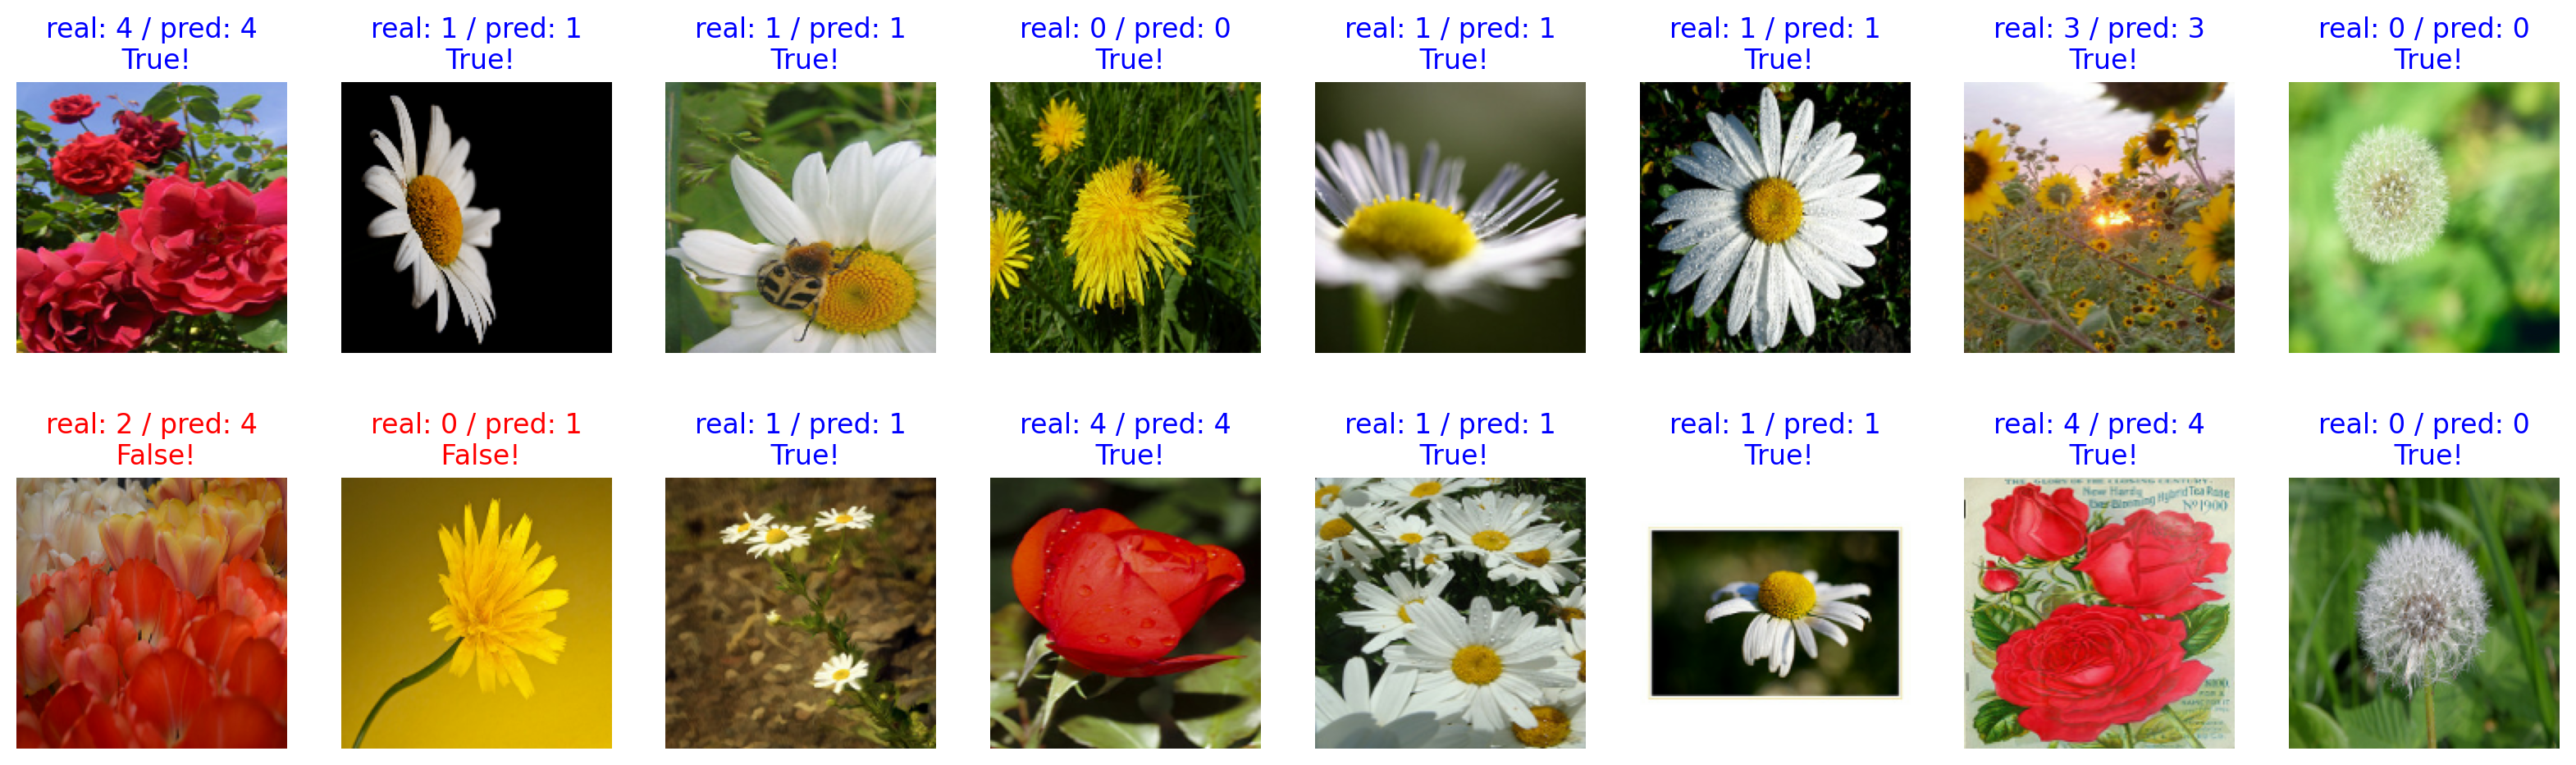

In [32]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    # 이미지 픽셀의 범위를 -1~1에서 0~1로 변경
    image = (image + 1) / 2
    plt.imshow(image)

    # 실제 값과 예측값이 같을 경우 correct는 True
    correct = label == prediction
    title = f'real: {label} / pred: {prediction}\n {correct}!'

    if not correct:
        plt.title(title, fontdict={'color':'red'})
    else:
        plt.title(title, fontdict={'color':'blue'})

    plt.axis('off')

색이나 꽃잎의 각도가 애매한 사진을 제외하면 전체적으로 잘 분류를 했다고 판단할 수 있을 것 같다.

#### 평가 데이터에 대한 정확도 확인
* 전체 평가 데이터 중 실제 값과 같은 예측을 한 데이터의 비율을 계산한다.

In [33]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 16 * 100)

87.5


평가 데이터의 정확도는 87.5%가 나왔다.  
클래스가 존재하는 임의의 이미지와 클래스가 존재하지 않는 임의의 데이터를 넣으면 어떤 결과가 나오는지 확인해보도록 한다.

### 모델 활용하기
---

#### 모델 저장
* 만들어진 모델을 언제든 불러와 사용할 수 있도록 저장한다.

In [34]:
import os

# 모델 저장 경로 지정
checkpoint_dir = os.getenv('HOME') + '/git/Aiffel_Node/Data/flower/checkpoint'
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

# 지정한 경로에 해당 디렉터리가 없을 경우 예외 처리
if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')

model.save_weights(checkpoint_file_path)

if os.path.exists(checkpoint_file_path):
    print('Complete to make checkpoint file!')

Complete to make checkpoint file!


#### 임의의 꽃 이미지를 가져와서 이미지 분류기 활용
* 임의로 꽃 이미지를 가져와서 각 케이스 별 결과를 확인한다. 케이스는 아래와 같다.
    * 클래스가 정해지지 않은 꽃 이미지
    * 클래스가 정해진 꽃 이미지
    * 클래스가 정해진 꽃 그림

In [46]:
# 이미지 파일 경로 지정
img_dir_path = os.getenv('HOME') + '/git/Aiffel_Node/Data/flower/images'

# 이미지 로드, 확인, 변환, 예측, 결과 출력을 한 번에 진행하는 함수 정의
def show_and_predict_image(dirpath, filename, img_size=IMG_SIZE):
    # 이미지 파일 접근
    filepath = os.path.join(dirpath, filename)
    # 이미지 파일 로드
    image = load_img(filepath, target_size=(img_size, img_size))
    # 이미지 파일 확인
    plt.imshow(image)
    plt.axis('off')
    # 이미지 파일 형태 변환
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    # 모델을 통한 분류 진행
    prediction = model.predict(image)[0]

    # 각 클래스 별 퍼센티지 연산
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulip_percentage = round(prediction[2] * 100)
    sunflower_percentage = round(prediction[3] * 100)
    rose_percentage = round(prediction[4] * 100)

    # 결과 출력
    print(f"This image seems {dandelion_percentage}% dandelion, {daisy_percentage}% daisy, {tulip_percentage}% tulip, {sunflower_percentage}% sunflower, and {rose_percentage}% rose.")

이미지 파일이 있는 경로에 접근하여 이미지를 로드한 후, 모델의 입력 형태에 맞게 변환한 다음 이미지를 분류, 결과 확인까지 시켜주는 함수를 정의한다.

1/1 [==============================] - 0s 72ms/step
This image seems 0% dandelion, 0% daisy, 0% tulip, 0% sunflower, and 100% rose.


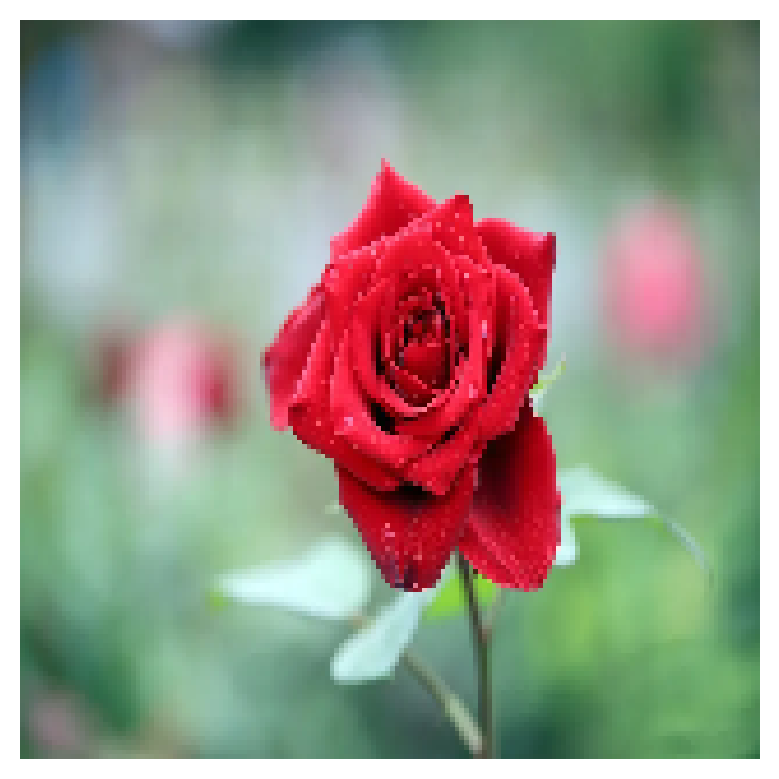

In [48]:
filename = 'rose.jpg'

# 장미 이미지 결과 확인
show_and_predict_image(img_dir_path, filename)

장미 이미지는 예상대로 100% 장미라고 올바르게 분류했다. 그렇다면 클래스가 존재하지 않는 꽃과 사진이 아닌 그림은 어떻게 분류를 하는지 알아보자.

1/1 [==============================] - 0s 71ms/step
This image seems 0% dandelion, 0% daisy, 100% tulip, 0% sunflower, and 0% rose.


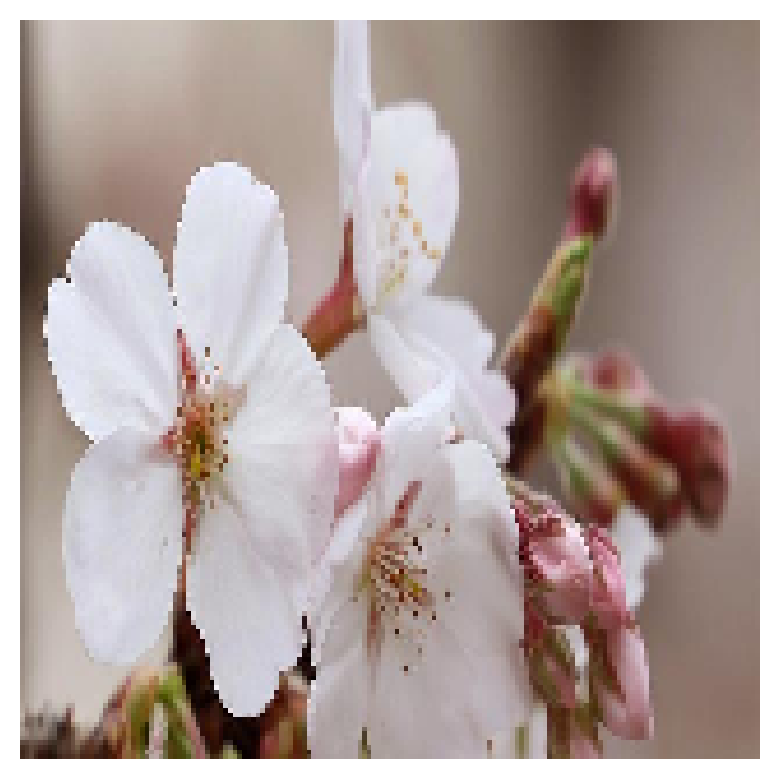

In [50]:
filename = 'cherryblossom.jpg'

# 벚꽃 이미지 결과 확인
show_and_predict_image(img_dir_path, filename)

민들레 혹은 데이지로 분류를 하는 결과가 나올줄 알았는데, 의외의 클래스인 튤립이 나왔다.  
민들레 그림도 한 번 결과를 확인해보자.

1/1 [==============================] - 0s 75ms/step
This image seems 0% dandelion, 2% daisy, 20% tulip, 0% sunflower, and 78% rose.


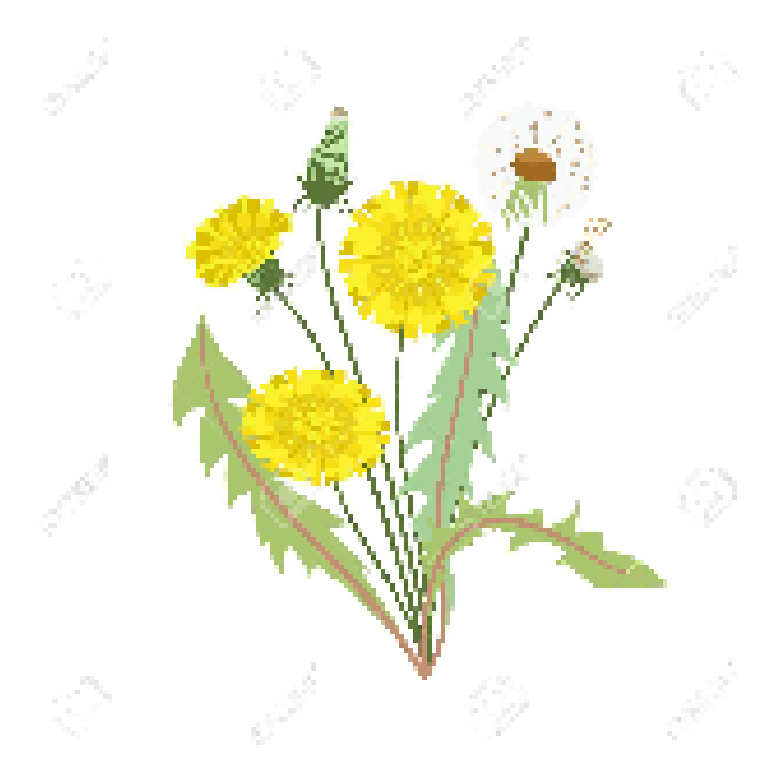

In [51]:
filename = 'dandelion.jpg'

# 민들레 그림 이미지 결과 확인
show_and_predict_image(img_dir_path, filename)

예상 외로 민들레는 0%가 나오고 데이지, 튤립, 장미가 각각 2%, 20%, 78%를 차지했다.  
우리가 가장 보편적으로 알고 있는 해바라기 그림을 한 번 이미지 분류기에 넣었을 때에는 어떤 결과가 나올지 갑자기 궁금해지므로 바로 시도해본다.

1/1 [==============================] - 0s 82ms/step
This image seems 0% dandelion, 0% daisy, 0% tulip, 100% sunflower, and 0% rose.


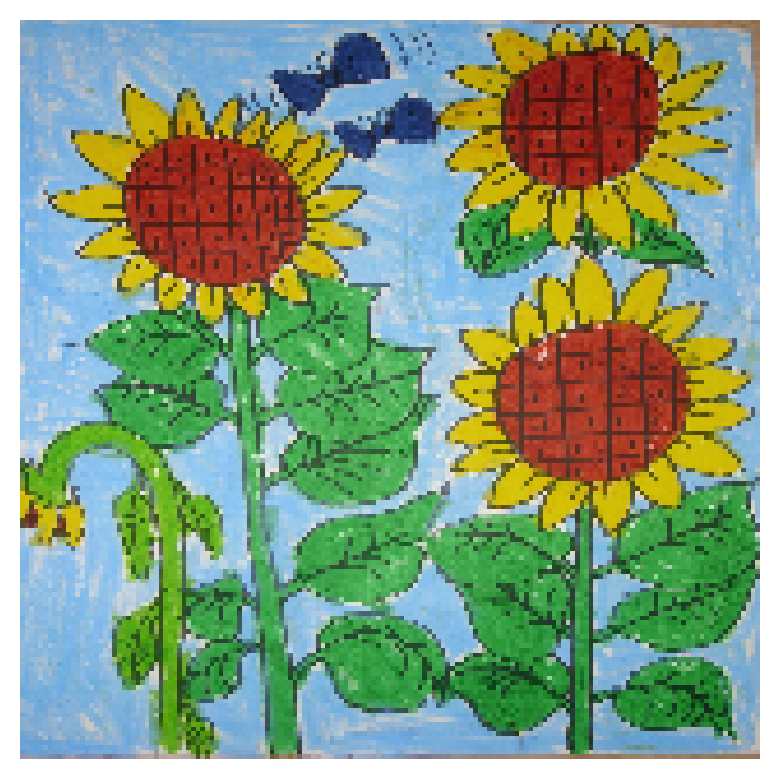

In [52]:
filename = 'sunflower1.jpg'

# 초등학생이 그린 해바라기 그림 이미지 결과 확인
show_and_predict_image(img_dir_path, filename)

초등학생이 그린 해바라기 그림보다 위에서 확인한 민들레 그림이 더 실제와 가깝다고 생각하는데, 내가 만든 이미지 분류기는 초등학생이 그린 해바라기 그림을 100% 해바라기라고 분류를 했다.  
그렇다면 세상에서 제일 유명한 해바라기 그림은 어떻게 분류를 할까?

1/1 [==============================] - 0s 71ms/step
This image seems 0% dandelion, 0% daisy, 0% tulip, 0% sunflower, and 100% rose.


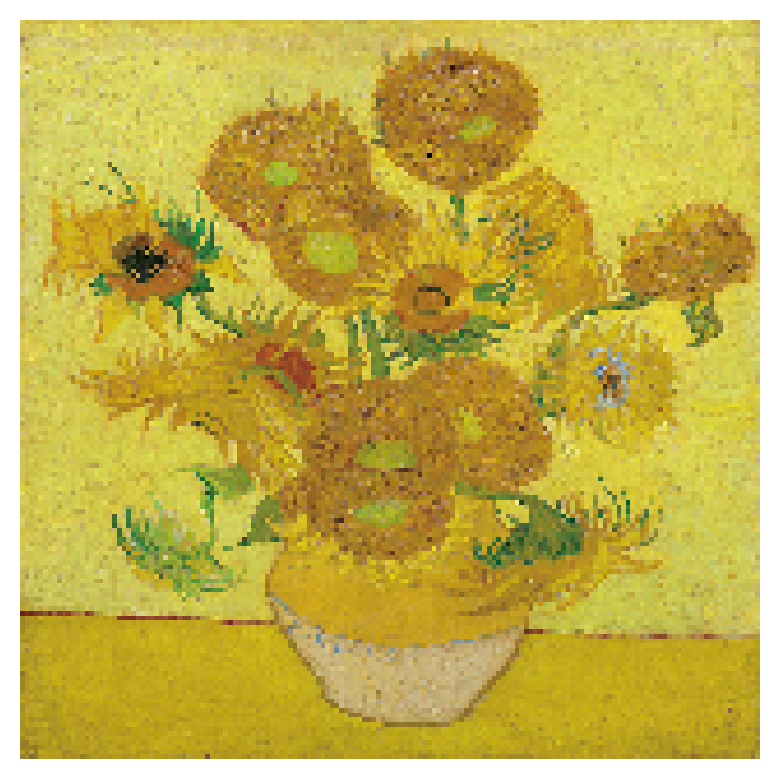

In [53]:
filename = 'sunflower2.jpg'

# 빈센트 반 고흐의 해바라기 그림 이미지 결과 확인
show_and_predict_image(img_dir_path, filename)

결과는 고흐가 초등학생한테 졌다.
고흐가 그린 해바라기 그림은 100% 장미라고 분류를 했다.

## 회고

<br>

<br>

### SUMMARY
---
노드를 따라 진행하는 것이 아닌, 지금까지 학습한 내용으로 내가 직접 코딩을 하여 이미지 분류기를 만들어봤다.  
비록 정확도는 87.5%로 그다지 높지 않은 점수이고 시간이 촉박하여 정확도를 올리려는 시도를 해보지는 못했지만, 검증 데이터에 대한 점수와 평가 데이터에 대한 점수도 나쁘지 않고 오버피팅 문제도 의심되지 않아 1차 시도로써는 만족하고 있다.  
특히 마지막 임의의 데이터로 모델을 평가해보는 중에 그림 이미지도 성공적으로 분류를 진행한 결과가 나와서 이미지 분류기에 대한 흥미가 더 높아졌다.  

<br>

### KPT
---
#### KEEP
* 코드의 복붙이 아닌, 직접 쳐가며 한 줄 한 줄을 이해했다.
* 그래프를 그리는 방법에 대해 이해하며 진행했다.
#### PROBLEM
* 사소한 것에 시간이 너무 오래 걸려 많은 시도를 하지 못했다.
* 예제 코드 없이 백지 상태에서 코딩을 진행하기 막막하다.
#### TRY
* 반복적으로 모델을 만들어보는 연습을 통해 진행 속도를 늘리고 자주 쓰는 코드들을 익힌다.